## Notebook to show posts creation trends for tag

### Description
This notebook shows top trending tags and progress, based on aggregations done in the previous notebook.
Top trending tags are defined as tags which `TagShare` share increased the most for the observation period, e.g. 3 years. 

### Input
This notebook takes as an input `posts_creation_trends.csv` file, produced by the previous step.

### Output
This notebook does not produce any files. 

### Setup

In [1]:
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta
import plotly.graph_objects as go
import plotly.io as pio

from config import get_file_path

pio.renderers.default = 'notebook_connected' # To make possible render charts inside Jupyter

In [2]:
# Utility function for working with year-month operations
def subtract_months(year_month: str, month_count: int) -> str:
    date = datetime.strptime(year_month, "%Y-%m")
    new_date = date - relativedelta(months=month_count)
    return new_date.strftime("%Y-%m")

def past_years_dates(year_month: str, years: int) -> list[str]:
    months = range(0, years * 12 + 1)
    return list([subtract_months(year_month, month) for month in months])

In [3]:
tag_trends_path = get_file_path('tag_trends.csv')
tag_trends_df = pd.read_csv(tag_trends_path)
tag_trends_df

,Tag,CreationDate,TagTotalActivityScore,TotalActivityScore,TagShare,TagRank
0,.a,2010-01,361,21380180,0.001688,4884.0
1,.a,2010-03,364,24298257,0.001498,5359.0
2,.a,2010-04,434,25736070,0.001686,5143.0
3,.a,2011-02,437,42108507,0.001038,7263.0
4,.a,2011-05,455,48750127,0.000933,7923.0
...,...,...,...,...,...,...
3650769,zyte,2023-06,90,297998257,0.000030,20458.0
3650770,zyte,2023-09,91,299232836,0.000030,19269.0
3650771,zyte,2023-12,100,300234127,0.000033,18045.0
3650772,zyte,2024-01,104,300559060,0.000035,18872.0


### Calculate delta for tag share and tag rank for observation period

In [4]:
def delta_by(df, source_column: str, multiplier: int = 1):
    start_column = f'Start{source_column}'
    end_column = f'End{source_column}'
    
    def extract_first_last(x):
        return pd.Series([x.iloc[0], x.iloc[-1]], index=[start_column, end_column])

    delta_df = df.\
        groupby('Tag')[source_column].\
        apply(extract_first_last).\
        unstack()
    
    delta_df[f'{source_column}Delta'] = multiplier * (delta_df[end_column] - delta_df[start_column])
    return delta_df

In [55]:
observation_period_years = 3
start_date = tag_trends_df["CreationDate"].max()
dates = past_years_dates(start_date, observation_period_years)

print(f'Start date: {start_date}')
print(f'Dates: {dates}')

Start date: 2024-03
Dates: ['2024-03', '2024-02', '2024-01', '2023-12', '2023-11', '2023-10', '2023-09', '2023-08', '2023-07', '2023-06', '2023-05', '2023-04', '2023-03', '2023-02', '2023-01', '2022-12', '2022-11', '2022-10', '2022-09', '2022-08', '2022-07', '2022-06', '2022-05', '2022-04', '2022-03', '2022-02', '2022-01', '2021-12', '2021-11', '2021-10', '2021-09', '2021-08', '2021-07', '2021-06', '2021-05', '2021-04', '2021-03']


In [56]:
latest_tag_trends_df = tag_trends_df[tag_trends_df["CreationDate"].isin(dates)]

tag_share_delta_df = delta_by(latest_tag_trends_df, 'TagShare')
tag_rank_delta_df = delta_by(latest_tag_trends_df, 'TagRank', -1) # Multiply delta by -1 because rank value increase has opposite meaning then in other metric cases

latest_tags_trends_delta_df =  tag_share_delta_df. \
    merge(tag_rank_delta_df, on='Tag', how='inner'). \
    reset_index()
latest_tags_trends_delta_df

,Tag,StartTagShare,EndTagShare,TagShareDelta,StartTagRank,EndTagRank,TagRankDelta
0,.a,1.116610e-03,1.062239e-03,-5.437093e-05,10253.0,9485.0,768.0
1,.app,6.132677e-04,6.145432e-04,1.275527e-06,13035.0,11526.0,1509.0
2,.aspxauth,2.099831e-04,2.090577e-04,-9.253556e-07,16779.0,15270.0,1509.0
3,.class-file,1.357616e-03,1.342952e-03,-1.466374e-05,9260.0,8349.0,911.0
4,.csproj.in,1.027501e-06,2.333761e-06,1.306259e-06,22680.0,20808.0,1872.0
...,...,...,...,...,...,...,...
54411,zynq,6.244772e-04,6.730395e-04,4.856231e-05,12949.0,11197.0,1752.0
54412,zynq-ultrascale+,1.265588e-05,3.060962e-05,1.795375e-05,23379.0,19045.0,4334.0
54413,zynqmp,6.647304e-07,6.647304e-07,0.000000e+00,21261.0,21261.0,-0.0
54414,zypper,1.327059e-04,1.458861e-04,1.318022e-05,19074.0,15367.0,3707.0


### Find top trending tags

In [57]:
top_tags_trends_count = 10
top_tags_trends_delta_df = latest_tags_trends_delta_df.sort_values(by='TagShareDelta', ascending=False)[0:top_tags_trends_count]
top_tags_trends_delta_df

,Tag,StartTagShare,EndTagShare,TagShareDelta,StartTagRank,EndTagRank,TagRankDelta
37622,python,8.810830,9.339611,0.528781,2.0,2.0,-0.0
39619,reactjs,1.241718,1.588594,0.346876,28.0,20.0,8.0
16726,flutter,0.436962,0.641511,0.204549,80.0,57.0,23.0
49384,typescript,0.805759,0.961976,0.156217,42.0,38.0,4.0
34342,pandas,0.952074,1.098120,0.146046,37.0,33.0,4.0
38597,r,1.613965,1.758538,0.144573,19.0,19.0,-0.0
31658,node.js,1.796068,1.894887,0.098818,18.0,18.0,-0.0
10835,dart,0.304894,0.399665,0.094771,121.0,90.0,31.0
37642,python-3.x,0.982737,1.077354,0.094617,36.0,34.0,2.0
11151,dataframe,0.502394,0.594033,0.091639,64.0,59.0,5.0


In [58]:
top_trending_tags = list(top_tags_trends_delta_df['Tag'])

months = 12 * observation_period_years
tag_trends_timeline_df = tag_trends_df[tag_trends_df['Tag'].isin(top_trending_tags)].\
    groupby('Tag').\
    agg(
        {
            'TagShare': lambda x: list(x)[-months:],
            'TagRank': lambda x: list(x)[-months:],
            'CreationDate': lambda x: list(x)[-months:]
        }
    ).\
    reset_index()
tag_trends_timeline_df

,Tag,TagShare,TagRank,CreationDate
0,dart,"[0.3094956686170886, 0.3144831875142482, 0.319...","[117.0, 114.0, 111.0, 108.0, 108.0, 108.0, 108...","[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."
1,dataframe,"[0.5061644342149679, 0.5101181470057146, 0.514...","[64.0, 64.0, 63.0, 63.0, 63.0, 63.0, 62.0, 61....","[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."
2,flutter,"[0.4460392420231101, 0.4562089682812938, 0.465...","[79.0, 75.0, 74.0, 71.0, 68.0, 67.0, 65.0, 65....","[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."
3,node.js,"[1.801367601291339, 1.80845093346268, 1.813698...","[18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....","[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."
4,pandas,"[0.959165733970776, 0.9661153957425302, 0.9730...","[37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37....","[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."
5,python,"[8.836309375878576, 8.862979887063126, 8.88606...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."
6,python-3.x,"[0.9899417176567096, 0.9959491914863008, 1.000...","[36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36....","[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."
7,r,"[1.6203778738240933, 1.6267560911650147, 1.632...","[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....","[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."
8,reactjs,"[1.2578278528999185, 1.2734700938482046, 1.287...","[28.0, 28.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27....","[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."
9,typescript,"[0.8122648029464805, 0.8180792960099791, 0.823...","[42.0, 42.0, 40.0, 40.0, 40.0, 39.0, 39.0, 39....","[2021-04, 2021-05, 2021-06, 2021-07, 2021-08, ..."


## Show charts for top trending tags

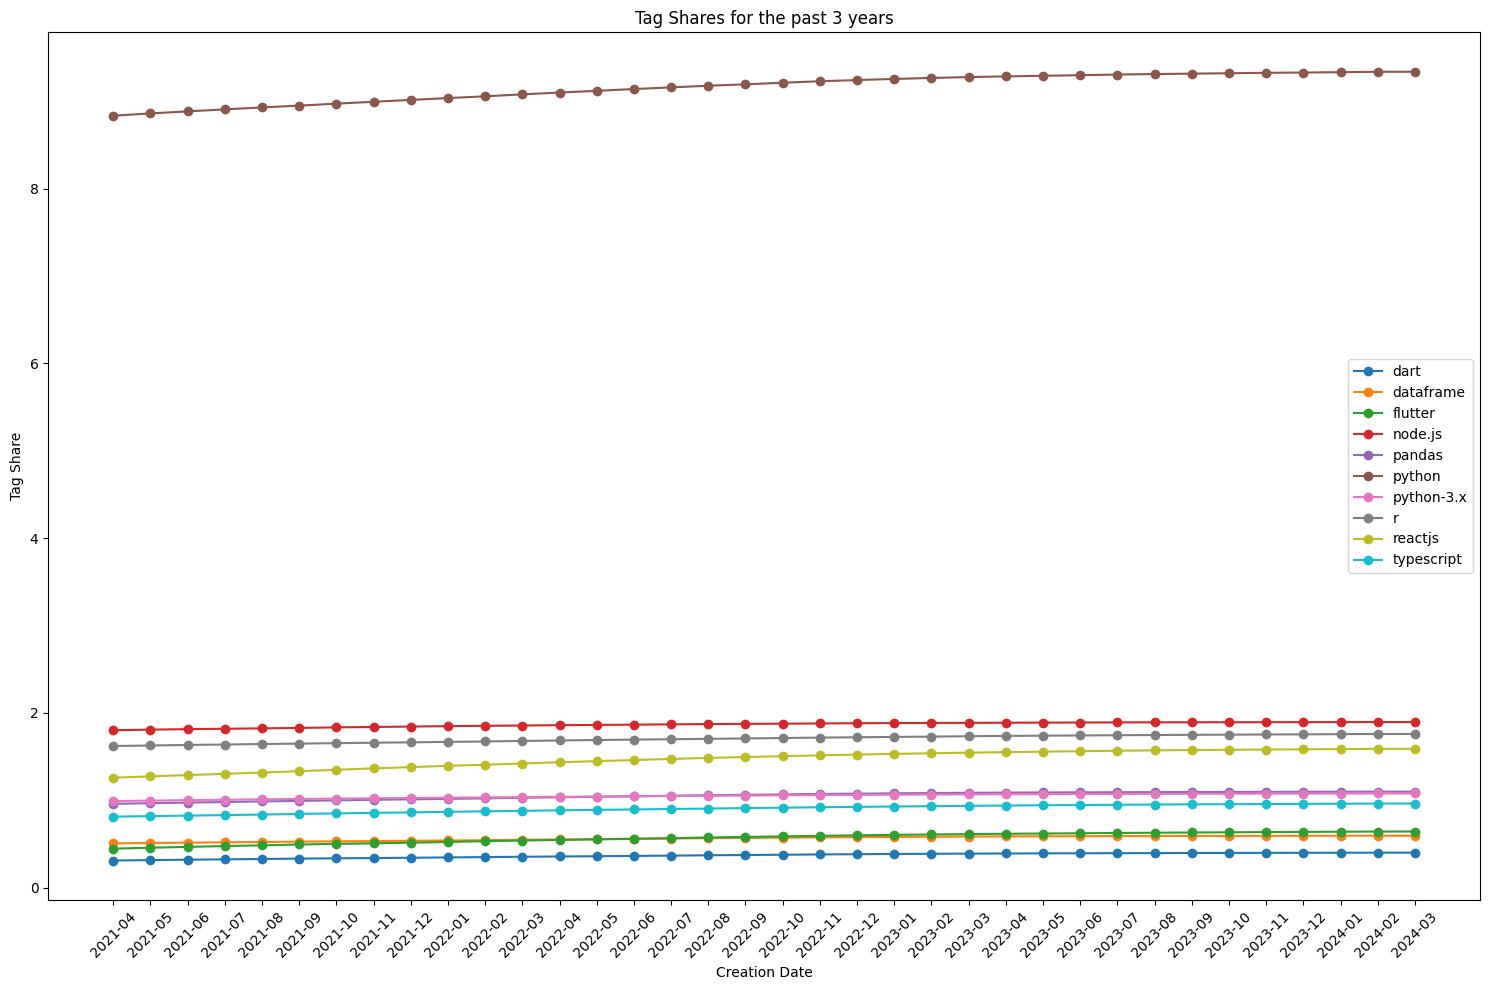

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))

for index, row in tag_trends_timeline_df.iterrows():
    ax.plot(row['CreationDate'], row['TagShare'], label=row['Tag'], marker='o')

ax.set_xlabel('Creation Date')
ax.set_ylabel('Tag Share')
ax.set_title(f'Tag Shares for the past {observation_period_years} years')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

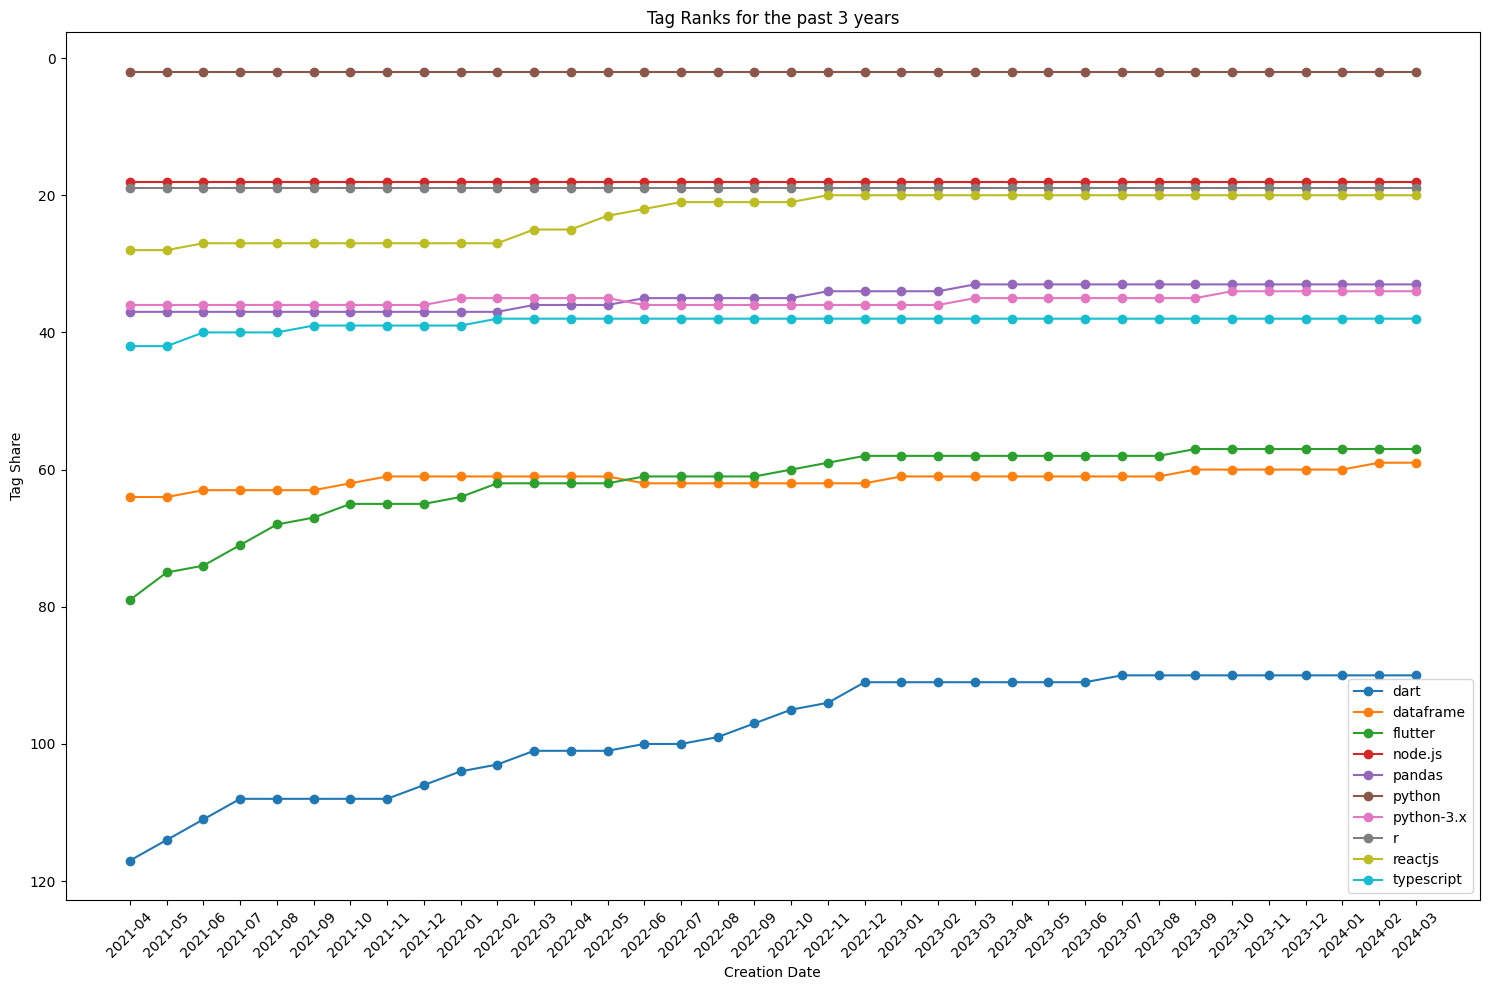

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))

for index, row in tag_trends_timeline_df.iterrows():
    ax.plot(row['CreationDate'], row['TagRank'], label=row['Tag'], marker='o')

ax.set_xlabel('Creation Date')
ax.set_ylabel('Tag Share')
ax.set_title(f'Tag Ranks for the past {observation_period_years} years')
ax.legend()

ax.invert_yaxis()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Find bottom trending tags

In [61]:
bottom_tags_trends_count = 10
bottom_tags_trends_delta_df = latest_tags_trends_delta_df.sort_values(by='TagShareDelta', ascending=True)[0:bottom_tags_trends_count]
bottom_tags_trends_delta_df

,Tag,StartTagShare,EndTagShare,TagShareDelta,StartTagRank,EndTagRank,TagRankDelta
24366,jquery,4.435586,4.160852,-0.274734,8.0,9.0,-1.0
23568,java,8.537771,8.265979,-0.271793,3.0,3.0,-0.0
35281,php,5.513660,5.277424,-0.236236,6.0,6.0,-0.0
6839,c#,7.719259,7.497657,-0.221602,4.0,4.0,-0.0
1441,android,6.112944,5.922738,-0.190206,5.0,5.0,-0.0
22970,ios,3.195123,3.051379,-0.143744,11.0,11.0,-0.0
32596,objective-c,1.537701,1.420968,-0.116733,20.0,24.0,-4.0
30384,mysql,2.612765,2.519262,-0.093504,13.0,13.0,-0.0
18324,git,2.046067,1.957620,-0.088447,16.0,17.0,-1.0
23117,iphone,1.157034,1.069157,-0.087877,31.0,35.0,-4.0


### Find fast growing trending tags

In [62]:
tag_trends_tag_share_line_df = latest_tag_trends_df.\
    sort_values(by=['Tag', 'CreationDate'], ascending=True).\
    groupby('Tag').\
    agg(
        {
            'TagShare': lambda x: list(x),
            'TagRank': lambda x: list(x),
            'CreationDate': lambda x: list(x)
        }
    ).\
    reset_index()
tag_trends_tag_share_line_df

,Tag,TagShare,TagRank,CreationDate
0,.a,"[0.0011166100903693, 0.0011130359268438, 0.001...","[10253.0, 10112.0, 10071.0, 10059.0, 10041.0, ...","[2021-03, 2021-04, 2021-06, 2021-08, 2021-09, ..."
1,.app,"[0.0006132677180266, 0.0006145110974742, 0.000...","[13035.0, 12746.0, 12680.0, 12633.0, 12595.0, ...","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ..."
2,.aspxauth,"[0.0002099830629967, 0.0002100582714185, 0.000...","[16779.0, 16454.0, 16414.0, 16464.0, 16346.0, ...","[2022-01, 2022-02, 2022-05, 2022-08, 2022-11, ..."
3,.class-file,"[0.0013576156661081, 0.0013486928375696, 0.001...","[9260.0, 9226.0, 9239.0, 9215.0, 9137.0, 9199....","[2021-04, 2021-06, 2021-07, 2021-09, 2021-10, ..."
4,.csproj.in,"[1.0275012982992654e-06, 2.333760792739334e-06]","[22680.0, 20808.0]","[2022-08, 2023-11]"
...,...,...,...,...
54411,zynq,"[0.0006244772105141, 0.0006229578461255, 0.000...","[12949.0, 12609.0, 12555.0, 12516.0, 12509.0, ...","[2021-03, 2021-05, 2021-06, 2021-07, 2021-08, ..."
54412,zynq-ultrascale+,"[1.265587861493703e-05, 1.4156329979946496e-05...","[23379.0, 21837.0, 21539.0, 21215.0, 21676.0, ...","[2021-03, 2021-09, 2021-11, 2021-12, 2022-01, ..."
54413,zynqmp,[6.647303890268461e-07],[21261.0],[2024-02]
54414,zypper,"[0.0001327059271909, 0.00013327614658, 0.00013...","[19074.0, 18503.0, 18301.0, 18260.0, 18076.0, ...","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ..."


In [63]:
import numpy as np

def calculate_slope(arr):
    if len(arr) <= 1:
        return np.nan  # Not enough data to calculate a slope
    X = np.arange(len(arr)).reshape(-1, 1)
    Y = np.array(arr).reshape(-1, 1)
    
    A = np.hstack([X, np.ones_like(X)])
    
    # Performing the linear regression calculation
    result = np.linalg.lstsq(A, Y, rcond=None)
    slope = result[0][0]
    return slope[0]

# Apply the function to each row in the 'TagShare' column
tag_trends_tag_share_line_df['TagShareSlope'] = tag_trends_tag_share_line_df['TagShare'].apply(calculate_slope)
top_growing_tag_trends_df = tag_trends_tag_share_line_df.sort_values(by=['TagShareSlope'], ascending=False)[0:top_tags_trends_count]
top_growing_tag_trends_df

,Tag,TagShare,TagRank,CreationDate,TagShareSlope
37622,python,"[8.81082996076768, 8.836309375878576, 8.862979...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ...",0.015107
39619,reactjs,"[1.241718151232868, 1.2578278528999185, 1.2734...","[28.0, 28.0, 28.0, 27.0, 27.0, 27.0, 27.0, 27....","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ...",0.009901
16726,flutter,"[0.4369619274107618, 0.4460392420231101, 0.456...","[80.0, 79.0, 75.0, 74.0, 71.0, 68.0, 67.0, 65....","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ...",0.005786
49384,typescript,"[0.805758931004941, 0.8122648029464805, 0.8180...","[42.0, 42.0, 42.0, 40.0, 40.0, 40.0, 39.0, 39....","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ...",0.004509
34342,pandas,"[0.9520739052687598, 0.959165733970776, 0.9661...","[37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37....","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ...",0.004215
38597,r,"[1.613965147337479, 1.6203778738240933, 1.6267...","[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ...",0.004145
10835,dart,"[0.3048942180985753, 0.3094956686170886, 0.314...","[121.0, 117.0, 114.0, 111.0, 108.0, 108.0, 108...","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ...",0.002699
11151,dataframe,"[0.5023942662361136, 0.5061644342149679, 0.510...","[64.0, 64.0, 64.0, 63.0, 63.0, 63.0, 63.0, 62....","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ...",0.002692
31658,node.js,"[1.7960684151486166, 1.801367601291339, 1.8084...","[18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ...",0.002680
37642,python-3.x,"[0.9827369295735612, 0.9899417176567096, 0.995...","[36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36....","[2021-03, 2021-04, 2021-05, 2021-06, 2021-07, ...",0.002537
